In [8]:
import sys
sys.path.insert(1, '/ai/gno/CODE/GPNO/')

import yaml
import torch
import matplotlib.pyplot as plt
import os.path as osp
from matplotlib.patches import Ellipse
import numpy as np

from trainers.builder import *
from datasets import NavierStokesDataset

torch.cuda.set_device(device=1)

In [9]:
ns_set = NavierStokesDataset(
    data_path="/ai/gno/DATA/ns/ns_V1e-5_N1200_T20.mat",
    sample_factor=1,
    in_t=1,
    out_t=1,
    duration_t=10,
    train_batchsize=1,
    eval_batchsize=1,
    train_ratio=0.8,
    valid_ratio=0.1,
    test_ratio=0.1,
    normalize=True,
    normalizer_type='PGN',
)

Loading processed data from  /ai/gno/DATA/ns/ns_V1e-5_N1200_T20_processed.pt


In [10]:
# gpo_dir = '/ai/gno/CODE/GPNO/logs/NavierStokes/04_09/GPO_17_46_12'
gpo_dir = '/ai/gno/CODE/GPNO/logs/NavierStokes/05_04/GPO_01_18_39'
gpo_args_path = osp.join(gpo_dir, 'config.yaml')
gpo_path = osp.join(gpo_dir, 'best_model.pth')
gpo_args = yaml.load(open(gpo_args_path, 'r'), Loader=yaml.FullLoader)
gpo = GPOTrainer(gpo_args).build_model(gpo_args)
gpo.load_state_dict(torch.load(gpo_path))
gpo.cuda()
gpo.eval()

GPO(
  (gs_field): GaussianField(
    (encoder): DynamicGaussianEncoder(
      (mlp_mu): Sequential(
        (0): Linear(in_features=3, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=256, bias=True)
      )
      (mlp_sigma): Sequential(
        (0): Linear(in_features=3, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=256, bias=True)
        (3): Softplus(beta=1.0, threshold=20.0)
      )
    )
    (decoder): GaussianDecoder(
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layers): FNO2d(
    (fc0): Linear(in_features=128, out_features=16, bias=True)
    (sp_convs): ModuleList(
      (0-3): 4 x SpectralConv2d()
    )
    (ws): ModuleList(
      (0): Conv1d(16, 2

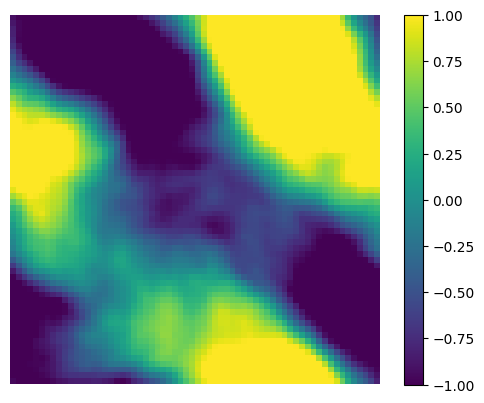

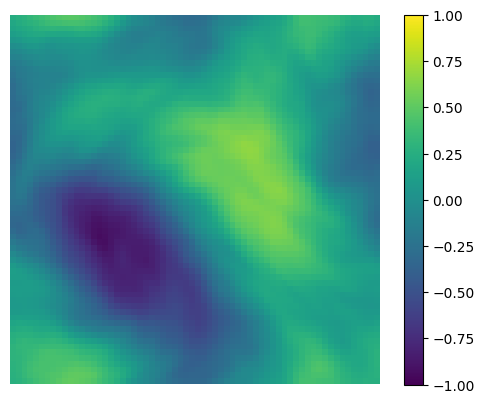

In [11]:
# vis_x = ns_set.test_dataset.x[128:129]
# vis_y = ns_set.test_dataset.y[128:129]

vis_x = ns_set.test_dataset.x[38:39]
vis_y = ns_set.test_dataset.y[38:39]

# vis_x = ns_set.test_dataset.x[28:29]
# vis_y = ns_set.test_dataset.y[28:29]

# plt.figure(dpi=1000)

heatmap = plt.imshow(vis_x[..., 2].reshape(64,64), cmap='viridis', interpolation='nearest', vmin=-1, vmax=1, origin='lower')
plt.axis("off")
plt.colorbar(heatmap)
plt.show()

heatmap = plt.imshow(vis_y.reshape(64,64), cmap='viridis', interpolation='nearest', vmin=-1, vmax=1, origin='lower')
plt.axis("off")
plt.colorbar(heatmap)
plt.show()

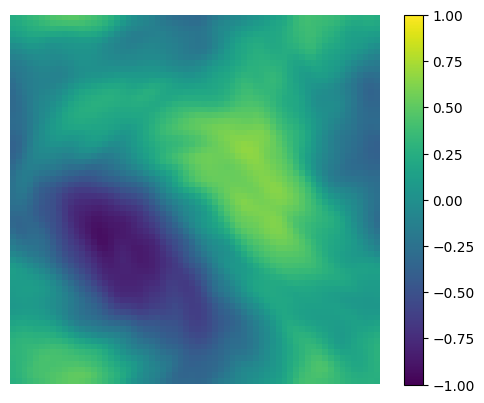

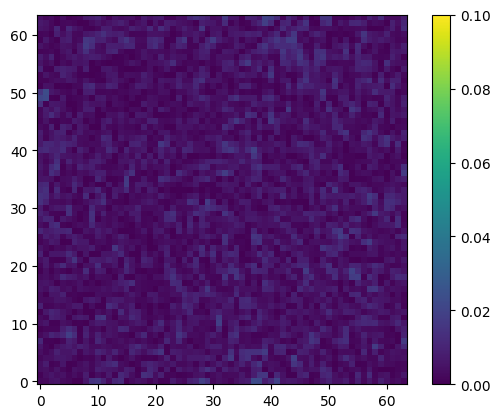

In [14]:
pred_y, pred_z = gpo(vis_x.cuda())
pred_y = pred_y.cpu().detach().reshape(64, 64)
# plt.figure(dpi=1000)
heatmap = plt.imshow(pred_y, cmap='viridis', interpolation='nearest', vmin=-1, vmax=1, origin='lower')
plt.axis("off")
plt.colorbar(heatmap)
plt.show()

error = torch.abs(pred_y.reshape(64,64) - vis_y.reshape(64, 64))
# plt.figure(dpi=1000)
heatmap = plt.imshow(error, cmap='viridis', interpolation='nearest', vmin=0, vmax=0.1, origin='lower')
# plt.axis("off")
plt.colorbar(heatmap)
plt.show()

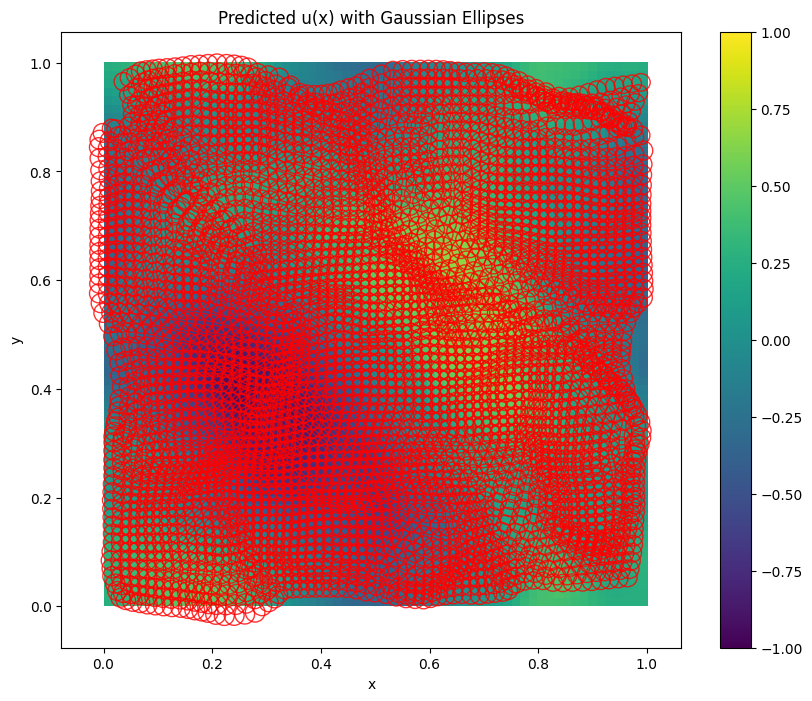

In [13]:
mu, sigma, weight = gpo.gs_field.encode_gaussian(vis_x.cuda())

mu = mu.squeeze(0)
sigma = sigma.squeeze(0)

mu = mu.cpu().detach().numpy()
sigma = sigma.cpu().detach().numpy()
weight = weight.cpu().detach().numpy()

N, G, d = mu.shape

fig, ax = plt.subplots(figsize=(10,8))

heatmap = ax.imshow(pred_y.reshape(64,64), cmap='viridis', interpolation='nearest', vmin=-1, vmax=1, origin='lower', extent=[0.0, 1.0, 0.0, 1.0])
plt.colorbar(heatmap)

sample_idx = np.random.choice(4096, size=min(4096, 4096), replace=False)

# for n in sample_idx:
#     # 对每个点，找到weight最大的Gaussian
#     g_top = np.argmax(abs(weight))  # 全局weight，如果是per-point weight可以是weight[n,:]
#     center = mu[n, g_top, :]
#     scale = sigma[n, g_top, :]

#     width = scale[0] * 0.1
#     height = scale[1] * 0.1
#     angle = 0

#     ellipse = Ellipse(
#         xy=(center[0], center[1]),
#         width=width,
#         height=height,
#         angle=angle,
#         edgecolor='red',
#         facecolor='none',
#         lw=1,
#         alpha=0.6
#     )
#     ax.add_patch(ellipse)
for n in sample_idx:
    # normalize weights
    w_n = np.abs(weight) + 1e-6
    w_n = w_n / np.sum(w_n)  # (G,)

    mu_n = mu[n]  # (G,2)
    sigma_n = sigma[n]  # (G,2)

    # 融合中心
    mu_fused = (w_n[:,None] * mu_n).sum(axis=0)  # (2,)

    # 融合尺度
    sigma_fused = (w_n[:,None] * (sigma_n**2 + (mu_n - mu_fused)**2)).sum(axis=0)  # (2,)

    width = np.sqrt(sigma_fused[0]) * 0.1
    height = np.sqrt(sigma_fused[1]) * 0.1
    angle = 0

    ellipse = Ellipse(
        xy=(mu_fused[0], mu_fused[1]),
        width=width,
        height=height,
        angle=angle,
        edgecolor='red',
        facecolor='none',
        lw=1,
        alpha=0.8
    )
    ax.add_patch(ellipse)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted u(x) with Gaussian Ellipses')
plt.axis('equal')
plt.show()